In [1]:
import numpy as np
import pylab as pl
# import waveform
# import CrossCorrelation

In [2]:
def template(f, gamma, t):
    return 10*np.sin(2*np.pi*f*t)*np.exp(-gamma*t)

In [3]:
def compute_stat(T, s):
    '''
    T: The template
    s: The portion of the data containing the signal
    '''
    T_dot_s = np.sum(T*s)
    T_diffsq_s = np.sum((T - s)**2)
    
    return np.abs(T_dot_s/(1 + T_diffsq_s)**3)
    
    

In [4]:
def likelihood(T, s):
    x = np.sum((T-s)**2)
    return -0.5*x
    

In [5]:
def create_data(freq, gamma, timestamps, signal_amplitude=1, noise_scale_factor=1, gaussian=False):
    signal = signal_amplitude*template(freq, gamma, timestamps)
    if gaussian:
        noise = noise_scale_factor*np.random.randn(len(timestamps))
    else:
        noise = -noise_scale_factor + 2*noise_scale_factor*np.random.random(len(timestamps))
    return [timestamps, (signal + noise), signal]

In [46]:
def plot_data(data, show_signal=False):
    pl.rcParams.update({'font.size': 18})
    pl.figure(figsize=(20,10))
    pl.plot(data[0], data[1], 'k')
    if show_signal:
        pl.plot(data[0], data[2], 'r')
    pl.xlabel('Time')
    pl.ylabel('Amplitude')
    pl.show()

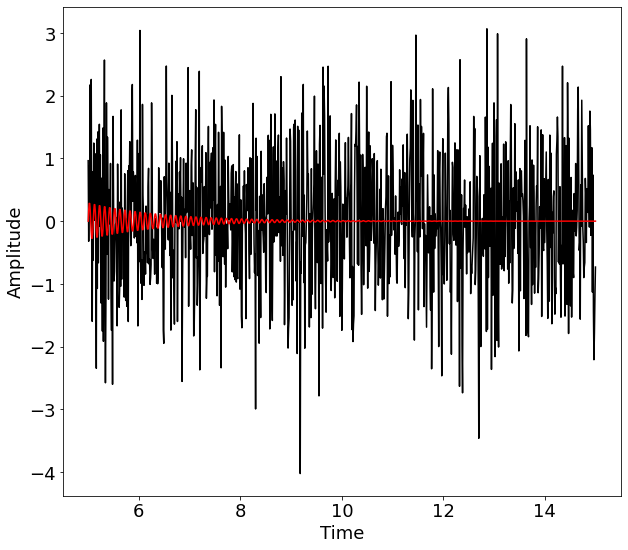

In [14]:
times = np.arange(5, 15+0.01, 0.01)
data = create_data(10, 0.7, times, noise_scale_factor=1, gaussian=True)
plot_data(data, show_signal=True)

### Parameter estimation
Assume that the search code has given us the true time stamps of the event. So, in this case we know that the start and end time of the signal are at $t=5$ and $t=15$ respectively. Furthermore, we will assume that amplitude is known in the first attempt. Thus the only parameters that are of interest in this case are the frequency and the attenuation functions.

In [17]:
frequencies = np.linspace(1, 25, 300, endpoint=True)
gammas = np.linspace(0, 10, 300, endpoint=True)
all_likelihoods = []
param_map = {}
index = 0
for f in frequencies:
    for g in gammas:
        param_map[index] = (f, g)
        y = template(f, g, times)
        all_likelihoods.append(likelihood(y, data[1]))
        index += 1
all_likelihoods = np.array(all_likelihoods)

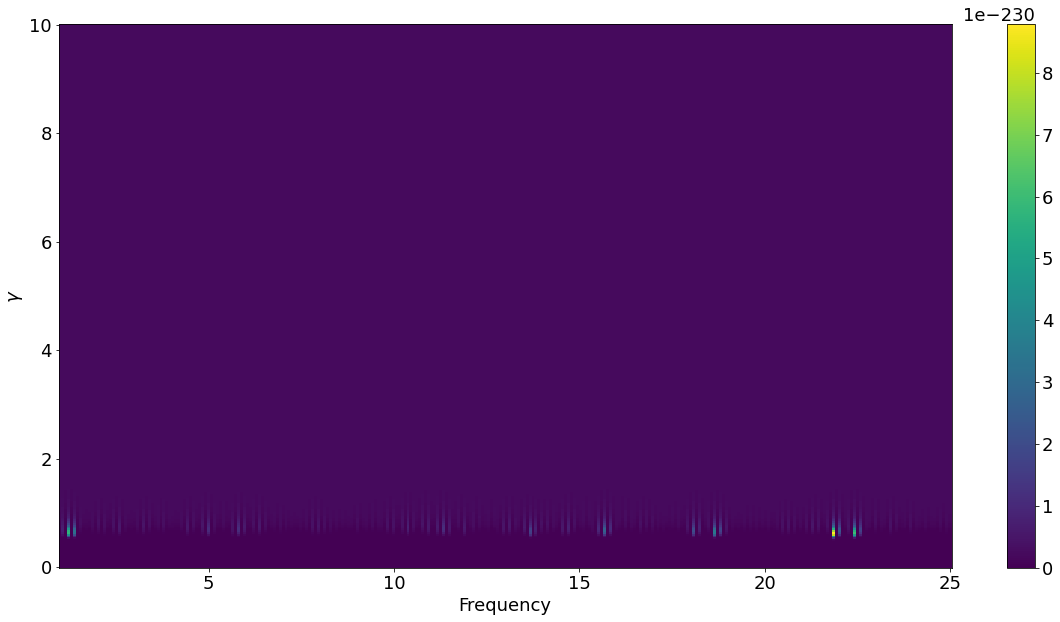

Maximum likelihood estimator: f = 21.869565217391305; gamma = 0.6354515050167224


In [18]:
F_GRID, G_GRID = np.meshgrid(frequencies, gammas)
L_grid = all_likelihoods.reshape(len(frequencies), len(gammas))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
pl.pcolormesh(F_GRID, G_GRID, np.exp(L_grid.T), shading='auto')
# pl.pcolormesh(F_GRID, G_GRID, L_grid.T, shading='auto')

pl.xlabel('Frequency')
pl.ylabel('$\\gamma$')
pl.colorbar()
pl.show()
ML_params = param_map[np.argmax(all_likelihoods)]
print('Maximum likelihood estimator: f = {}; gamma = {}'.format(ML_params[0], ML_params[1]))

## Explore alternative signals

$y(t) = 10\sin[2\pi ft\{1 + \sin(2\pi \delta t)\}]e^{-\gamma t}$

In [577]:
def template2(f, gamma, delta, t):
    phase1 = delta*t**0.2
    phase2 = gamma*t**0.3
    y = 10*(np.sin(2*np.pi*f*phase1*t) + np.sin(2*np.pi*f*phase2*t))
    return y
#     return 10*np.sin(2*np.pi*f*t*(1 + np.sin(2*np.pi*delta*t))) * np.exp(-gamma*t)

In [578]:
def create_data2(freq, gamma, delta, timestamps, signal_amplitude=1, noise_scale_factor=1, gaussian=False):
    signal = signal_amplitude*template2(freq, gamma, delta, timestamps)
    if gaussian:
        noise = noise_scale_factor*np.random.randn(len(timestamps))
    else:
        noise = -noise_scale_factor + 2*noise_scale_factor*np.random.random(len(timestamps))
    return [timestamps, (signal + noise), signal]

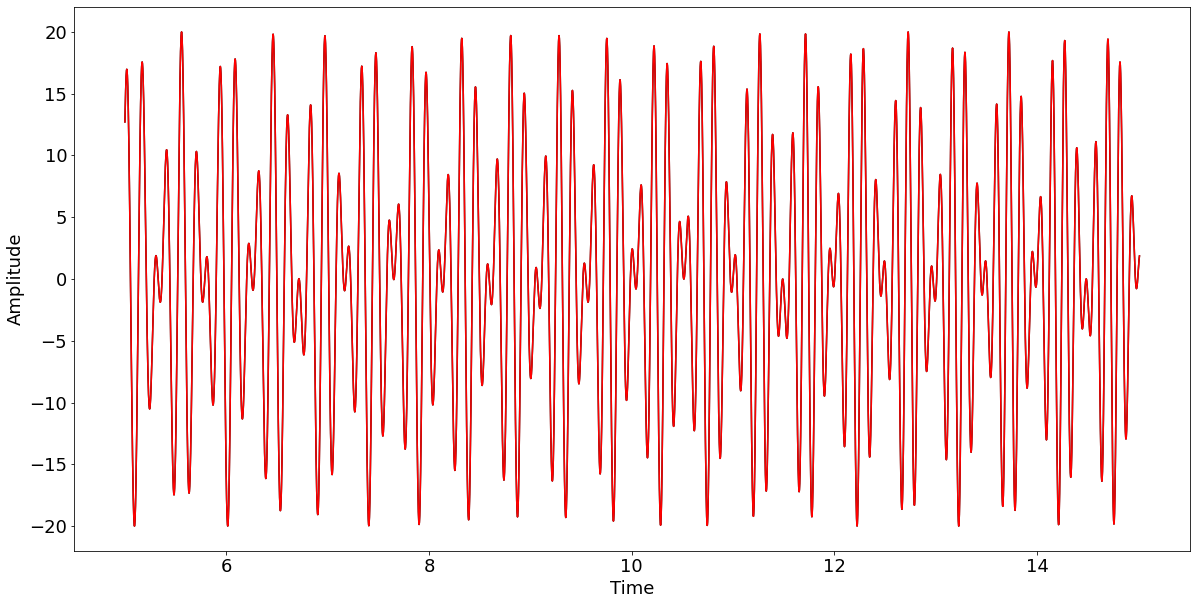

In [579]:
times = np.arange(5, 15+0.01, 0.001)
data = create_data2(5, 0.5, 0.9, times, noise_scale_factor=0., gaussian=True)
plot_data(data, show_signal=True)

In [580]:
frequencies = np.linspace(4, 6, 50, endpoint=True)
gammas = np.linspace(0.4, 0.6, 50, endpoint=True)
deltas = np.linspace(0.8, 1.0, 50, endpoint=True)
all_likelihoods = []
f_vals = []
g_vals = []
d_vals = []
param_map = {}
index = 0
for f in frequencies:
    for g in gammas:
        for d in deltas:
            param_map[index] = (f, g, d)
            y = template2(f, g, d, times)
            L = likelihood(y, data[1])
            all_likelihoods.append(L)
            f_vals.append(f)
            g_vals.append(g)
            d_vals.append(d)
            index += 1
all_likelihoods = np.array(all_likelihoods)
f_vals = np.array(f_vals)
g_vals = np.array(g_vals)
d_vals = np.array(d_vals)

In [581]:
param_map[np.argmax(all_likelihoods)]

(5.1020408163265305, 0.4897959183673469, 0.8816326530612245)

In [582]:
# Marginalization over delta
L_fg = []
for f in frequencies:
    for g in gammas:
        index = (f_vals == f)*(g_vals == g)
        L_fg.append(np.mean(all_likelihoods[index]))
L_fg = np.array(L_fg)

In [583]:
# Marginalization over gamma
L_fd = []
for f in frequencies:
    for d in deltas:
        index = (f_vals == f)*(d_vals == d)
        L_fd.append(np.mean(all_likelihoods[index]))
L_fd = np.array(L_fd)

In [584]:
# Marginalization over frequency
L_gd = []
for g in gammas:
    for d in deltas:
        index = (g_vals == g)*(d_vals == d)
        L_gd.append(np.mean(all_likelihoods[index]))
L_gd = np.array(L_gd)

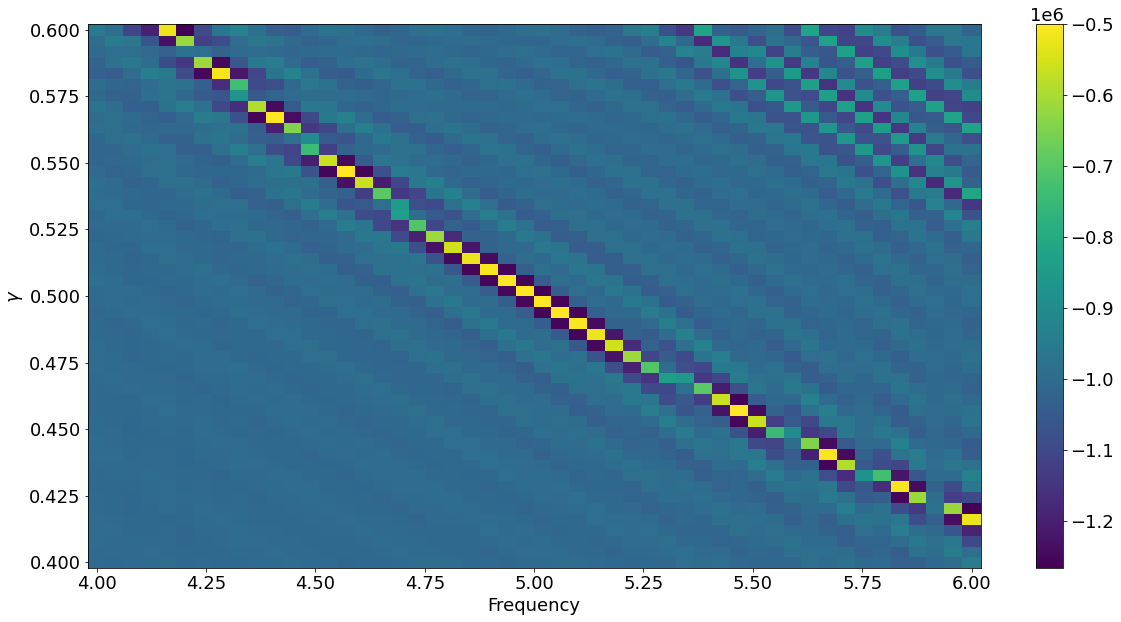

In [585]:
F_GRID, G_GRID = np.meshgrid(frequencies, gammas)
L_grid = L_fg.reshape(len(frequencies), len(gammas))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
# pl.pcolormesh(F_GRID, G_GRID, np.exp(L_grid.T), shading='auto')
pl.pcolormesh(F_GRID, G_GRID, L_grid.T, shading='auto')

pl.xlabel('Frequency')
pl.ylabel('$\\gamma$')
pl.colorbar()
pl.show()

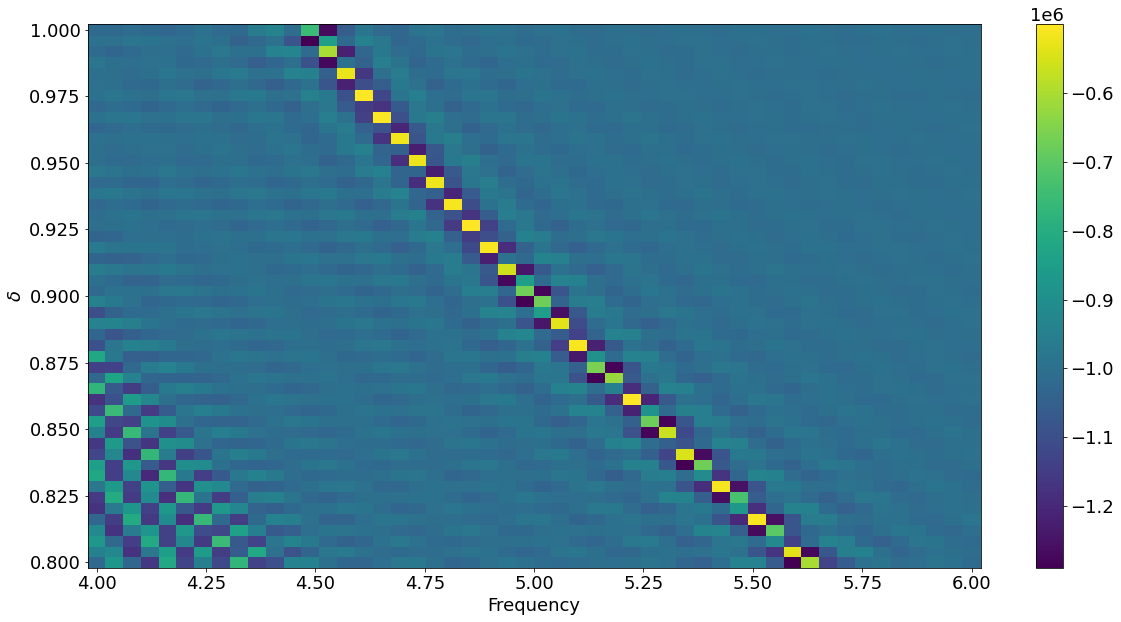

In [586]:
F_GRID, D_GRID = np.meshgrid(frequencies, deltas)
L_grid = L_fd.reshape(len(frequencies), len(deltas))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
# pl.pcolormesh(F_GRID,DG_GRID, np.exp(L_grid.T), shading='auto')
pl.pcolormesh(F_GRID, D_GRID, L_grid.T, shading='auto')

pl.xlabel('Frequency')
pl.ylabel('$\\delta$')
pl.colorbar()
pl.show()

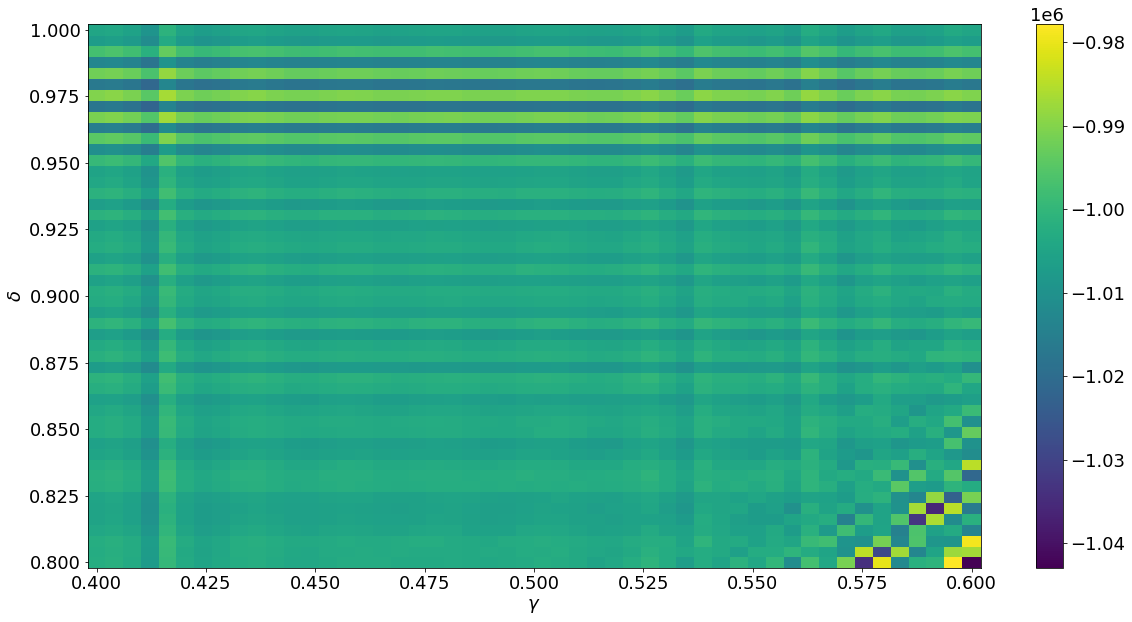

In [587]:
G_GRID, D_GRID = np.meshgrid(gammas, deltas)
L_grid = L_gd.reshape(len(gammas), len(deltas))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
# pl.pcolormesh(G_GRID,DG_GRID, np.exp(L_grid.T), shading='auto')
pl.pcolormesh(G_GRID, D_GRID, L_grid.T, shading='auto')

pl.xlabel('$\\gamma$')
pl.ylabel('$\\delta$')
pl.colorbar()
pl.show()

In [588]:
# Marginalized frequency likelihood distribution
L_f = []
for f in frequencies:
    index = f_vals == f
    L_f.append(np.mean(all_likelihoods[index]))
L_f = np.array(L_f)

# Marginalized gamma likelihood distribution
L_g = []
for g in gammas:
    index = g_vals == g
    L_g.append(np.mean(all_likelihoods[index]))
L_g = np.array(L_g)

# Marginalized delta likelihood distribution
L_d = []
for d in deltas:
    index = d_vals == d
    L_d.append(np.mean(all_likelihoods[index]))
L_d = np.array(L_d)


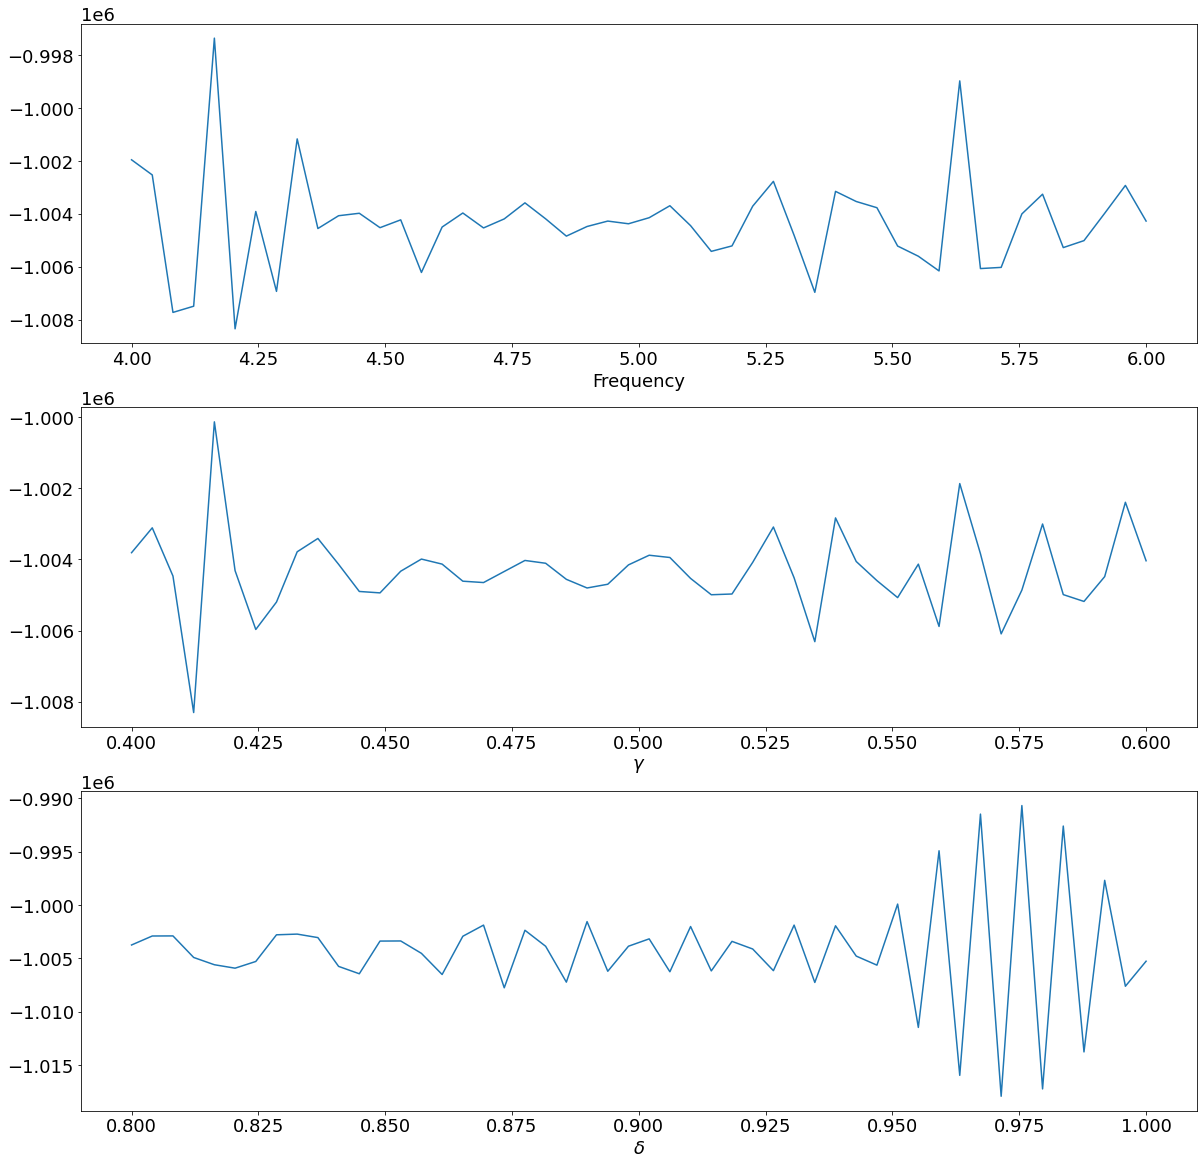

In [589]:
pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,20))
pl.subplot(3,1,1)
pl.plot(frequencies, L_f)
pl.xlabel('Frequency')
pl.subplot(3,1,2)
pl.plot(gammas, L_g)
pl.xlabel('$\\gamma$')
pl.subplot(3,1,3)
pl.plot(deltas, L_d)
pl.xlabel('$\\delta$')
pl.show()